## Package

In [2]:
!pwd

/Users/annalisadipasquali/Desktop/Project AI MODELS/PAPERS/Convolutional-KANs-master/architectures_28x28


In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

from architectures_28x28.CKAN_BN import CKAN_BN
from architectures_28x28.SimpleModels import *
from architectures_28x28.ConvNet import ConvNet
from architectures_28x28.KANConvs_MLP import KANC_MLP
from architectures_28x28.KKAN import KKAN_Convolutional_Network
from architectures_28x28.conv_and_kan import NormalConvsKAN


## Dataset

In [2]:
# Transformation 
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load MNIST and filtering for two classes 
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

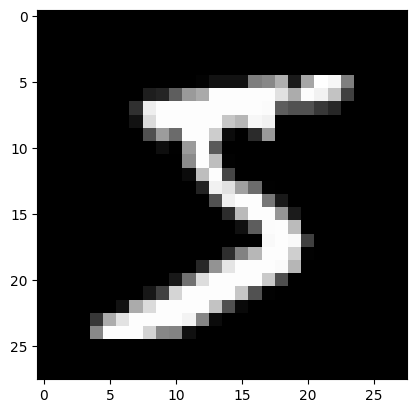

In [3]:
# print an image from the dataset 
plt.imshow(mnist_train[0][0].squeeze(), cmap='gray')

## Train & Test

In [4]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """
    Train the model for one epoch

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        optimizer: the optimizer to use (e.g. SGD)
        epoch: the current epoch
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        avg_loss: the average loss over the training set
    """

    model.to(device)
    model.train()
    train_loss = 0
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # Recall that GPU is optimized for the operations we are dealing with
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = criterion(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    # print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader, criterion):
    """
    Test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        test_loader: DataLoader for test data
        criterion: the loss function (e.g. CrossEntropy)

    Returns:
        test_loss: the average loss over the test set
        accuracy: the accuracy of the model on the test set
        precision: the precision of the model on the test set
        recall: the recall of the model on the test set
        f1: the f1 score of the model on the test set
    """

    model.eval()
    test_loss = 0
    correct = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += criterion(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += (target == predicted).sum().item()

            # Collect all targets and predictions for metric calculations
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate overall metrics
    precision = precision_score(all_targets, all_predictions, average='macro')
    recall = recall_score(all_targets, all_predictions, average='macro')
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Normalize test loss
    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)

    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}\n'.format(
    #     test_loss, correct, len(test_loader.dataset), accuracy, precision, recall, f1))

    return test_loss, accuracy, precision, recall, f1

In [5]:
def train_and_test_models(model, device, train_loader, test_loader, optimizer, criterion, epochs, scheduler):
    """
    Train and test the model

    Args:
        model: the neural network model
        device: cuda or cpu
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        optimizer: the optimizer to use (e.g. SGD)
        criterion: the loss function (e.g. CrossEntropy)
        epochs: the number of epochs to train
        scheduler: the learning rate scheduler

    Returns:
        all_train_loss: a list of the average training loss for each epoch
        all_test_loss: a list of the average test loss for each epoch
        all_test_accuracy: a list of the accuracy for each epoch
        all_test_precision: a list of the precision for each epoch
        all_test_recall: a list of the recall for each epoch
        all_test_f1: a list of the f1 score for each epoch
    """
    # Track metrics
    all_train_loss = []
    all_test_loss = []
    all_test_accuracy = []
    all_test_precision = []
    all_test_recall = []
    all_test_f1 = []
    
    for epoch in range(1, epochs + 1):
        # Train the model
        train_loss = train(model, device, train_loader, optimizer, epoch, criterion)
        all_train_loss.append(train_loss)
        
        # Test the model
        test_loss, test_accuracy, test_precision, test_recall, test_f1 = test(model, device, test_loader, criterion)
        all_test_loss.append(test_loss)
        all_test_accuracy.append(test_accuracy)
        all_test_precision.append(test_precision)
        all_test_recall.append(test_recall)
        all_test_f1.append(test_f1)

        print(f'End of Epoch {epoch}: Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}')
        scheduler.step()
    model.all_test_accuracy = all_test_accuracy
    model.all_test_precision = all_test_precision
    model.all_test_f1 = all_test_f1
    model.all_test_recall = all_test_recall

    return all_train_loss, all_test_loss, all_test_accuracy, all_test_precision, all_test_recall, all_test_f1

## Set Device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Common Models:
- SimpleCNN
- SimpleLinear
- ConvNet

In [9]:
model_SimpleCNN = SimpleCNN()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_and_test_models(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)

100%|██████████| 938/938 [00:09<00:00, 103.69it/s]


End of Epoch 1: Train Loss: 0.424062, Test Loss: 0.0022, Accuracy: 95.61%


100%|██████████| 938/938 [00:09<00:00, 102.77it/s]


End of Epoch 2: Train Loss: 0.126863, Test Loss: 0.0015, Accuracy: 96.89%


100%|█████████▉| 934/938 [00:09<00:00, 103.50it/s]


KeyboardInterrupt: 

In [9]:
summary(SimpleCNN_Anna(), (1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 28, 28]          640
├─MaxPool2d: 1-2                         [-1, 64, 14, 14]          --
├─Conv2d: 1-3                            [-1, 90, 14, 14]          51,930
├─MaxPool2d: 1-4                         [-1, 90, 7, 7]            --
├─Flatten: 1-5                           [-1, 4410]                --
├─Linear: 1-6                            [-1, 10]                  44,110
Total params: 96,680
Trainable params: 96,680
Non-trainable params: 0
Total mult-adds (M): 10.66
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.37
Estimated Total Size (MB): 0.89


In [10]:
model_SimpleCNN = SimpleCNN_Anna()
model_SimpleCNN.to(device)
optimizer_SimpleCNN = optim.AdamW(model_SimpleCNN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN, gamma=0.8)
criterion_SimpleCNN = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN, all_test_loss_SimpleCNN, all_test_accuracy_SimpleCNN, all_test_precision_SimpleCNN, all_test_recall_SimpleCNN, all_test_f1_SimpleCNN = train_and_test_models(model_SimpleCNN, device, train_loader, test_loader, optimizer_SimpleCNN, criterion_SimpleCNN, epochs=10, scheduler=scheduler_SimpleCNN)

100%|██████████| 938/938 [00:47<00:00, 19.71it/s]


End of Epoch 1: Train Loss: 0.137642, Test Loss: 0.0007, Accuracy: 98.55%


100%|██████████| 938/938 [00:41<00:00, 22.85it/s]


End of Epoch 2: Train Loss: 0.042339, Test Loss: 0.0006, Accuracy: 98.81%


100%|██████████| 938/938 [00:43<00:00, 21.64it/s]


End of Epoch 3: Train Loss: 0.028637, Test Loss: 0.0005, Accuracy: 99.12%


100%|██████████| 938/938 [00:43<00:00, 21.42it/s]


End of Epoch 4: Train Loss: 0.020072, Test Loss: 0.0005, Accuracy: 98.96%


100%|██████████| 938/938 [00:50<00:00, 18.70it/s]


End of Epoch 5: Train Loss: 0.013740, Test Loss: 0.0004, Accuracy: 99.25%


100%|██████████| 938/938 [00:47<00:00, 19.57it/s]


End of Epoch 6: Train Loss: 0.010396, Test Loss: 0.0004, Accuracy: 99.18%


100%|██████████| 938/938 [00:49<00:00, 19.13it/s]


End of Epoch 7: Train Loss: 0.007214, Test Loss: 0.0004, Accuracy: 99.15%


100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


End of Epoch 8: Train Loss: 0.005327, Test Loss: 0.0004, Accuracy: 99.18%


100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


End of Epoch 9: Train Loss: 0.003844, Test Loss: 0.0005, Accuracy: 99.10%


100%|██████████| 938/938 [00:40<00:00, 22.94it/s]


End of Epoch 10: Train Loss: 0.002992, Test Loss: 0.0004, Accuracy: 99.19%


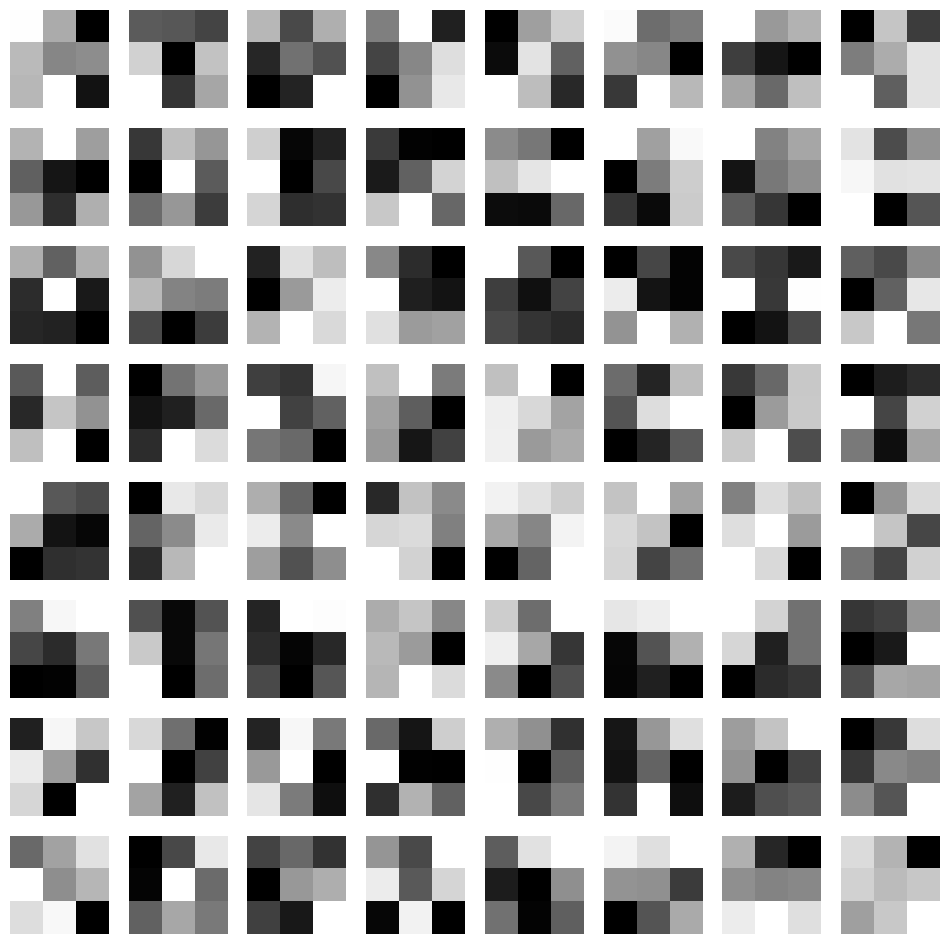

In [45]:
# Stampo i filtri del primo livello 

model = model_SimpleCNN

# Estrai i pesi del primo livello di convoluzione
filters = model.conv1.weight.data

# Definisci il numero di filtri da visualizzare
n_filters = filters.shape[0]

# Plotting
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()


for i in range(n_filters):
    ax = axes[i]
    ax.imshow(filters[i, 0, :, :].cpu(), cmap='grey')
    ax.axis('off')

plt.show()

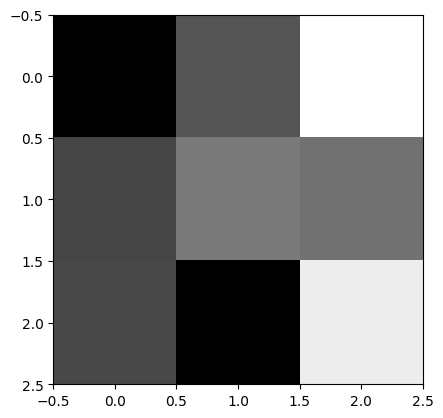

In [41]:
plt.imshow((1 - filters[0, 0, :, :].cpu()), cmap='gray')

In [20]:
model_SimpleCNN_2 = SimpleCNN_2()
model_SimpleCNN_2.to(device)
optimizer_SimpleCNN_2 = optim.AdamW(model_SimpleCNN_2.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleCNN_2 = optim.lr_scheduler.ExponentialLR(optimizer_SimpleCNN_2, gamma=0.8)
criterion_SimpleCNN_2 = nn.CrossEntropyLoss()
all_train_loss_SimpleCNN_2, all_test_loss_SimpleCNN_2, all_test_accuracy_SimpleCNN_2, all_test_precision_SimpleCNN_2, all_test_recall_SimpleCNN_2, all_test_f1_SimpleCNN_2 = train_and_test_models(model_SimpleCNN_2, device, train_loader, test_loader, optimizer_SimpleCNN_2, criterion_SimpleCNN_2, epochs=10, scheduler=scheduler_SimpleCNN_2)

 28%|██▊       | 265/938 [00:02<00:07, 93.61it/s]


KeyboardInterrupt: 

In [ ]:
model_SimpleLinear = SimpleLinear()
model_SimpleLinear.to(device)
optimizer_SimpleLinear = optim.AdamW(model_SimpleLinear.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_SimpleLinear = optim.lr_scheduler.ExponentialLR(optimizer_SimpleLinear, gamma=0.8)
criterion_SimpleLinear = nn.CrossEntropyLoss()
all_train_loss_SimpleLinear, all_test_loss_SimpleLinear, all_test_accuracy_SimpleLinear, all_test_precision_SimpleLinear, all_test_recall_SimpleLinear, all_test_f1_SimpleLinear = train_and_test_models(model_SimpleLinear, device, train_loader, test_loader, optimizer_SimpleLinear, criterion_SimpleLinear, epochs=10, scheduler=scheduler_SimpleLinear)


In [ ]:
model_ConvNet = ConvNet()
model_ConvNet.to(device)
optimizer_ConvNet = optim.AdamW(model_ConvNet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_ConvNet = optim.lr_scheduler.ExponentialLR(optimizer_ConvNet, gamma=0.8)
criterion_ConvNet = nn.CrossEntropyLoss()
all_train_loss_ConvNet, all_test_loss_ConvNet, all_test_accuracy_ConvNet, all_test_precision_ConvNet, all_test_recall_ConvNet, all_test_f1_ConvNet = train_and_test_models(model_ConvNet, device, train_loader, test_loader, optimizer_ConvNet, criterion_ConvNet, epochs=10, scheduler=scheduler_ConvNet)


## Convolutional KAN

In [ ]:
model_KKAN_Convolutional_Network = KKAN_Convolutional_Network(device = device)
model_KKAN_Convolutional_Network.to(device)
optimizer_KKAN_Convolutional_Network = optim.AdamW(model_KKAN_Convolutional_Network.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KKAN_Convolutional_Network = optim.lr_scheduler.ExponentialLR(optimizer_KKAN_Convolutional_Network, gamma=0.8)
criterion_KKAN_Convolutional_Network = nn.CrossEntropyLoss()

all_train_loss_KKAN_Convolutional_Network, all_test_loss_KKAN_Convolutional_Network, all_test_accuracy_KKAN_Convolutional_Network, all_test_precision_KKAN_Convolutional_Network, all_test_recall_KKAN_Convolutional_Network, all_test_f1_KKAN_Convolutional_Network = train_and_test_models(model_KKAN_Convolutional_Network, device, train_loader, test_loader, optimizer_KKAN_Convolutional_Network, criterion_KKAN_Convolutional_Network, epochs=10, scheduler=scheduler_KKAN_Convolutional_Network)


In [ ]:
model_KANC_MLP= KANC_MLP(device = device)
model_KANC_MLP.to(device)
optimizer_KANC_MLP = optim.AdamW(model_KANC_MLP.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_KANC_MLP = optim.lr_scheduler.ExponentialLR(optimizer_KANC_MLP, gamma=0.8)
criterion_KANC_MLP = nn.CrossEntropyLoss()

all_train_loss_KANC_MLP, all_test_loss_KANC_MLP, all_test_accuracy_KANC_MLP, all_test_precision_KANC_MLP, all_test_recall_KANC_MLP, all_test_f1_KANC_MLP = train_and_test_models(model_KANC_MLP, device, train_loader, test_loader, optimizer_KANC_MLP, criterion_KANC_MLP, epochs=10, scheduler=scheduler_KANC_MLP)


In [ ]:
model_Convs_and_KAN= NormalConvsKAN()
model_Convs_and_KAN.to(device)
optimizer_Convs_and_KAN = optim.AdamW(model_Convs_and_KAN.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_Convs_and_KAN = optim.lr_scheduler.ExponentialLR(optimizer_Convs_and_KAN, gamma=0.8)
criterion_Convs_and_KAN = nn.CrossEntropyLoss()

all_train_loss_Convs_and_KAN, all_test_loss_Convs_and_KAN, all_test_accuracy_Convs_and_KAN, all_test_precision_Convs_and_KAN, all_test_recall_Convs_and_KAN, all_test_f1_Convs_and_KAN = train_and_test_models(model_Convs_and_KAN, device, train_loader, test_loader, optimizer_Convs_and_KAN, criterion_Convs_and_KAN, epochs=10, scheduler=scheduler_Convs_and_KAN)


## Results

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))  

ax1.plot(all_test_loss_SimpleCNN, label='Loss ConvNet(Small)', color='red')
ax1.plot(all_test_loss_SimpleLinear, label='Loss 1 Layer & MLP', color='green')
ax1.plot(all_test_loss_SimpleCNN_2, label='Loss ConvNet(Medium)', color='yellow')
ax1.plot(all_test_loss_ConvNet, label='Loss ConvNet (Big)', color='purple')
ax1.plot(all_test_loss_KANC_MLP, label='Loss KANConv & MLP', color='blue')
ax1.plot(all_test_loss_Convs_and_KAN, label='Loss Conv & KAN', color='gray')
ax1.plot(all_test_loss_KKAN_Convolutional_Network, label='Loss KKAN', color='orange')

ax1.set_title('Loss Test vs Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.scatter(count_parameters(model_SimpleCNN), max(all_test_accuracy_SimpleCNN), color='red', label='ConvNet (Small)')
ax2.scatter(count_parameters(model_SimpleLinear), max(all_test_accuracy_SimpleLinear), color='green', label='1 Layer MLP')
ax2.scatter(count_parameters(model_SimpleCNN_2), max(all_test_accuracy_SimpleCNN_2), color='yellow', label='ConvNet (Medium)')
ax2.scatter(count_parameters(model_ConvNet), max(all_test_accuracy_ConvNet), color='purple', label='ConvNet (Big)')
ax2.scatter(count_parameters(model_KANC_MLP), max(all_test_accuracy_KANC_MLP), color='blue', label='KANConv & MLP')
ax2.scatter(count_parameters(model_Convs_and_KAN), max(all_test_accuracy_Convs_and_KAN), color='grey', label='Convs & KAN')
ax2.scatter(count_parameters(model_KKAN_Convolutional_Network), max(all_test_accuracy_KKAN_Convolutional_Network), color='orange', label='KKAN')

ax2.set_title('Number of Parameters vs Accuracy')
ax2.set_xlabel('Number of Parameters')
ax2.set_ylabel('Accuracy (%)')
ax2.legend() 
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# Listas para acumular datos
accs = []
precision = []
recall = []
f1s = []
params_counts = []

# Modelos y sus métricas correspondientes
models = [model_SimpleLinear, model_SimpleCNN,model_SimpleCNN_2, model_ConvNet, model_KANC_MLP, model_Convs_and_KAN, model_KKAN_Convolutional_Network]
# all_accuracys = [all_test_accuracy_SimpleLinear, all_test_accuracy_SimpleCNN, all_test_accuracy_ConvNet, all_test_accuracy_KANC_MLP, all_test_accuracy_Convs_and_KAN, all_test_accuracy_KKAN_Convolutional_Network]
# all_precision = [all_test_precision_SimpleLinear, all_test_precision_SimpleCNN, all_test_precision_ConvNet, all_test_precision_KANC_MLP, all_test_precision_Convs_and_KAN, all_test_precision_KKAN_Convolutional_Network]
# all_recall = [all_test_recall_SimpleLinear, all_test_recall_SimpleCNN, all_test_recall_ConvNet, all_test_recall_KANC_MLP, all_test_recall_Convs_and_KAN, all_test_recall_KKAN_Convolutional_Network]
# all_f1s = [all_test_f1_SimpleLinear, all_test_f1_SimpleCNN, all_test_f1_ConvNet, all_test_f1_KANC_MLP, all_test_f1_Convs_and_KAN, all_test_f1_KKAN_Convolutional_Network]


# Recopilación de datos
for i, m in enumerate(models):
    index = np.argmax(m.all_test_accuracy)
    params_counts.append(count_parameters(m))
    accs.append(m.all_test_accuracy[index])
    precision.append(m.all_test_precision[index])
    recall.append(m.all_test_recall[index])
    f1s.append(m.all_test_f1[index])

# Creación del DataFrame
df = pd.DataFrame({
    "Test Accuracy": accs,
    "Test Precision": precision,
    "Test Recall": recall,
    "Test F1 Score": f1s,
    "Number of Parameters": params_counts
}, index=["1 Layer MLP", "ConvNet (Small)","ConvNet (Medium)", "ConvNet (Big)", "KANConv & MLP", "Simple Conv & KAN", "KKAN"])

df.to_csv('experiment_28x28.csv', index=False)

# Aplicando el estilo
df_styled = df.style.apply(highlight_max, subset=df.columns[:], axis=0).format('{:.3f}')

In [ ]:
df_styled